In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

#读取数据
df = pd.read_csv("/input/train_data.csv")  
data = np.array(df['铁路客运量_当期值(万人)'])

In [2]:
# 数据预处理
normalized_data = (data - np.mean(data)) / np.std(data)

seq_size = 3
train_x, train_y = [], []
for i in range(len(normalized_data) - seq_size - 1):
	train_x.append(np.expand_dims(normalized_data[i : i + seq_size], axis=1).tolist())
	train_y.append(normalized_data[i + 1 : i + seq_size + 1].tolist())

input_dim = 1
X = tf.placeholder(tf.float32, [None, seq_size, input_dim])
Y = tf.placeholder(tf.float32, [None, seq_size])

In [3]:
# regression
def ass_rnn(hidden_layer_size=6):
	W = tf.Variable(tf.random_normal([hidden_layer_size, 1]), name='W')
	b = tf.Variable(tf.random_normal([1]), name='b')
	cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
	outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
	W_repeated = tf.tile(tf.expand_dims(W, 0), [tf.shape(X)[0], 1, 1])
	out = tf.batch_matmul(outputs, W_repeated) + b
	out = tf.squeeze(out)
	return out

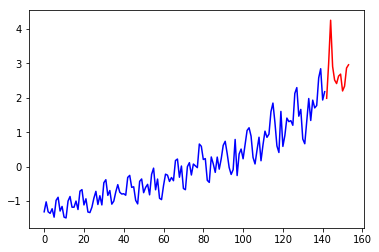

In [4]:
def prediction():
	out = ass_rnn()

	saver = tf.train.Saver(tf.global_variables())
	with tf.Session() as sess:
		#tf.get_variable_scope().reuse_variables()
		saver.restore(sess, 'output/ass.model')
		
		prev_seq = train_x[-1]
		predict = []
		for i in range(12):
			next_seq = sess.run(out, feed_dict={X: [prev_seq]})
			predict.append(next_seq[-1])
			prev_seq = np.vstack((prev_seq[1:], next_seq[-1]))

		plt.figure()
		plt.plot(list(range(len(normalized_data))), normalized_data, color='b')
		plt.plot(list(range(len(normalized_data), len(normalized_data) + len(predict))), predict, color='r')
		plt.show()

prediction()